In [1]:
import numpy as np
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
)
import matplotlib.pyplot as plt

In [2]:
import os
# Set working directory
os.chdir("D:/ACP")  # Windows path fix: use forward slash or raw string

print("Current Working Directory:", os.getcwd())

Current Working Directory: D:\ACP


In [3]:
# Step 1: Load the datasets (datasets were already splited and saved as csv files, 80,20 split)
train_data = pd.read_csv("acp_train_data.csv") #train data
test_data = pd.read_csv("acp_test_data.csv") #test data
# Step 2: Separate labels and features
y_train, X_train = train_data.iloc[:, 2], train_data.iloc[:, 3:] # third column: Label, # from fourth column onward: features
y_test, X_test = test_data.iloc[:, 2], test_data.iloc[:, 3:]

In [4]:
# Define Random Forest model and hyperparameter grid
rf_model = RandomForestClassifier(random_state=42) # Random state for reproducibility to get consistent results
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350], # Number of trees in the forest, default = 100, Range = 10-1000
    'max_depth': [10, 20, 30, 40, None], # Maximum depth of the tree, default = None, Range = 1-32, None = full tree
    'min_samples_split': [2, 5, 10, 20],# Minimum number of samples required to split an internal node, default = 2, Range = 2-20
    'min_samples_leaf': [1, 2, 4, 6, 8, 10], # Minimum number of samples required to be at a leaf node, default = 1, Range = 1-20
    'max_features': ['auto', 'sqrt', 'log2'], # Number of features to consider when looking for the best split, default = auto, Range = auto/sqrt/log2
}

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=1,
    cv=5,
    verbose=2
)
grid_search.fit(X_train, y_train)
# Print best parameters and model
print("Best Hyperparameters:", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_

# Save best hyperparameters to a file
with open('best_model_info_rf.txt', 'w') as f:
    f.write("Best Hyperparameters:\n")
    for param, value in grid_search.best_params_.items():
        f.write(f"{param}: {value}\n")

print("Best model information has been saved to 'best_model_info_rf.txt'")

Fitting 5 folds for each of 2520 candidates, totalling 12600 fits
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100

C:\Users\myousaf23\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
4200 fits failed out of a total of 12600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4200 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\myousaf23\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\myousaf23\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\myousaf23\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\myousaf23\a

Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best model information has been saved to 'best_model_info_rf.txt'


In [5]:
#save the model
joblib.dump(best_rf_model, "best_rf_model.pkl")

['best_rf_model.pkl']

In [6]:
# Step 8: Fit the model on the training data
best_rf_model.fit(X_train, y_train)

# Evaluate on test datasets
y_test_pred = best_rf_model.predict(X_test)
y_test_prob = best_rf_model.predict_proba(X_test)[:, 1]

# Print accuracies
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred) * 100:.2f}%")

# Confusion matrices
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test Data):\n", confusion_matrix_test)

# Sensitivity and Specificity calculation
def calculate_sensitivity_specificity(conf_matrix):
    tn, fp, fn, tp = conf_matrix.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity, specificity

sensitivity_test, specificity_test = calculate_sensitivity_specificity(confusion_matrix_test)
print("Test Data - Sensitivity:", sensitivity_test, "Specificity:", specificity_test)

Test Accuracy: 79.46%
Confusion Matrix (Test Data):
 [[72 19]
 [19 75]]
Test Data - Sensitivity: 0.7978723404255319 Specificity: 0.7912087912087912


In [7]:
print("Confusion Matrix (Test Data):")
print(f"TN: {confusion_matrix_test[0,0]}  FP: {confusion_matrix_test[0,1]}")
print(f"FN: {confusion_matrix_test[1,0]}  TP: {confusion_matrix_test[1,1]}")


Confusion Matrix (Test Data):
TN: 72  FP: 19
FN: 19  TP: 75


In [8]:
from sklearn.metrics import f1_score
# calculation of F1 score
f1_test = f1_score(y_test, y_test_pred)
print("F1 Score (Test Data):", f1_test)

F1 Score (Test Data): 0.7978723404255319


In [9]:
#calculation of classification report for test and evaluation data
print("Classification Report (Test Data):\n", classification_report(y_test, y_test_pred))

Classification Report (Test Data):
               precision    recall  f1-score   support

           0       0.79      0.79      0.79        91
           1       0.80      0.80      0.80        94

    accuracy                           0.79       185
   macro avg       0.79      0.79      0.79       185
weighted avg       0.79      0.79      0.79       185



In [10]:
# Evaluate on the test dataset
y_test_pred = best_rf_model.predict(X_test)
y_test_prob = best_rf_model.predict_proba(X_test)[:, 1]

Test Data ROC AUC: 0.8888239420154314
Test Data FPR: [0.         0.         0.         0.05494505 0.05494505 0.06593407
 0.06593407 0.07692308 0.07692308 0.08791209 0.08791209 0.0989011
 0.0989011  0.12087912 0.12087912 0.13186813 0.13186813 0.14285714
 0.14285714 0.15384615 0.15384615 0.16483516 0.16483516 0.1978022
 0.1978022  0.20879121 0.20879121 0.21978022 0.21978022 0.23076923
 0.23076923 0.25274725 0.25274725 0.27472527 0.27472527 0.28571429
 0.28571429 0.35164835 0.35164835 0.36263736 0.36263736 0.47252747
 0.47252747 0.51648352 0.51648352 0.6043956  0.6043956  0.61538462
 0.61538462 0.94505495 0.94505495 1.        ]
Test Data TPR: [0.         0.0106383  0.5        0.5        0.53191489 0.53191489
 0.54255319 0.54255319 0.55319149 0.55319149 0.59574468 0.59574468
 0.62765957 0.62765957 0.63829787 0.63829787 0.65957447 0.65957447
 0.67021277 0.67021277 0.73404255 0.73404255 0.75531915 0.75531915
 0.77659574 0.77659574 0.80851064 0.80851064 0.81914894 0.81914894
 0.84042553 0.840

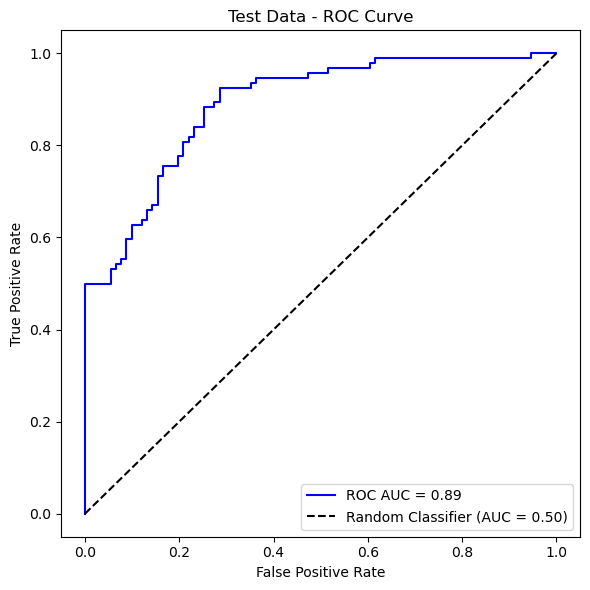

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generate ROC for test dataset
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Print the values
print("Test Data ROC AUC:", roc_auc_test)
print("Test Data FPR:", fpr_test)
print("Test Data TPR:", tpr_test)
print("Test Data Thresholds:", thresholds_test)

# Create a plot
fig, ax = plt.subplots(figsize=(6, 6))  # This defines 'ax' properly

# Plot ROC curve
ax.plot(fpr_test, tpr_test, label=f"ROC AUC = {roc_auc_test:.2f}", color="blue")
ax.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")
ax.set_title("Test Data - ROC Curve")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc="lower right")

# Adjust layout and save figure
plt.tight_layout()
plt.savefig("rf_roc_auc_curve.png", dpi=500)
print("ROC curve saved as 'rf_roc_auc_curve.png'.")

# Show the plot
plt.show()

In [13]:
# Perform 10-fold cross-validation on the best model
cross_val_scores = cross_val_score(best_rf_model, X_train, y_train, cv=10, scoring='accuracy')
print("10-Fold Cross-Validation Accuracy Scores:", cross_val_scores)
print("Mean 10-Fold CV Accuracy:", cross_val_scores.mean())

# save accuracy of each fold to a text file
with open('cv_accuracies_rf.txt', 'w') as f:
    f.write("Cross-Validation Accuracies for each fold:\n")
    for i, score in enumerate(cross_val_scores):
        f.write(f"Fold {i+1} Accuracy: {score:.4f}\n")

print("Accuracy of each fold has been saved to 'cv_accuracies_rf.txt'")

10-Fold Cross-Validation Accuracy Scores: [0.72972973 0.85135135 0.77027027 0.77027027 0.78378378 0.74324324
 0.82432432 0.78378378 0.79452055 0.80821918]
Mean 10-Fold CV Accuracy: 0.7859496482784154
Accuracy of each fold has been saved to 'cv_accuracies_rf.txt'


Mean Accuracy: 78.59
Mean AUC: 0.9997


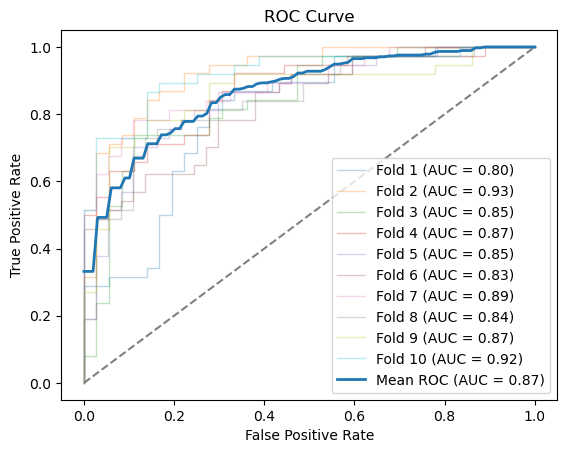

In [15]:
# make roc curve of all folds with mean auc and mean accuracy printed on the plot
mean_accuracy = cross_val_scores.mean() * 100
print(f"Mean Accuracy: {mean_accuracy:.2f}")
# Step 6: Generate ROC Curve
mean_auc = roc_auc_score(y_train, best_rf_model.predict_proba(X_train)[:, 1])
print(f"Mean AUC: {mean_auc:.4f}")

cv = StratifiedKFold(n_splits=10)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for i, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    best_rf_model.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
    y_prob = best_rf_model.predict_proba(X_train.iloc[test_idx])[:, 1]
    fpr, tpr, _ = roc_curve(y_train.iloc[test_idx], y_prob)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig("cv_roc_curve_rf.png", dpi=500)
plt.show()

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef
# Compute metrics
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
mcc = matthews_corrcoef(y_test, y_test_pred)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Matthews Correlation Coefficient (MCC):", mcc)

Precision: 0.7978723404255319
Recall: 0.7978723404255319
F1 Score: 0.7978723404255319
Matthews Correlation Coefficient (MCC): 0.5890811316343231
